# Data Challenge 2: Yammer User Engagement

Yammer is a social network for communicating with coworkers. Individuals share documents, updates, and ideas by posting them in groups. Yammer is free to use indefinitely, but companies must pay license fees if they want access to administrative controls, including integration with user management systems like ActiveDirectory.

Yammer has a centralized Analytics team, which sits in the Engineering organization. Their primary goal is to drive better product and business decisions using data. They do this partially by providing tools and education that make other teams within Yammer more effective at using data to make better decisions. They also perform ad-hoc analysis to support specific decisions.

#### The problem
You show up to work Tuesday morning, September 2, 2014. The head of the Product team walks over to your desk and asks you what you think about the latest activity on the user engagement dashboards.

Paraphrase: A quick look at user engagement over time (i.e. # users that logged in at least once during a week) shows a dip in users around August 1. This data challenge seeks to find out why there was a decrease in retention.

### Hypotheses: before examing the data
Before examining the data, some ideas come to mind that may play into why weekly users may have decreased during this time. The following are hypotheses:
* This falls towards the end of summer and could mark a common time for employees to go on vacation (country-dependent). I would check this by looking for average work hours of employees during the week of August 1. Should there be less hours, it could simply be a slow period of work and have nothing to do with Yammer.
* How are people accessing Yammer? Is it via his/her computer or via mobile device? There could be an issue with the website or app that might play a factor.
    * If there was an update to Yammer, there could have been bugs that disrupted normal usage.
* Too many emails being sent? Sometimes inundating users with useless emails causes them to start ignoring them and the service.
* Growth saturation? Dependent on company size?

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from datetime import datetime
import warnings
import time
from scipy import stats
import itertools
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler, Imputer, scale, normalize

### Load the Data

In [2]:
df_users = pd.read_csv('yammer_users.csv',dtype={"value": float})
df_emails = pd.read_csv('yammer_emails.csv',dtype={"value": float})
df_events = pd.read_csv('yammer_events.csv',dtype={"value": float})
df_rollup = pd.read_csv('dimension_rollup_periods.csv',dtype={"value": float})

In [3]:
df_users.head()

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active


#### Merge

In [4]:
df = df_users.merge(df_events,on='user_id',how='left')
df.set_index('user_id')
df.head()

,user_id,created_at,company_id,language,activated_at,state,occurred_at,event_type,event_name,location,device,user_type
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active,2014-05-13 09:31:47,engagement,login,India,lenovo thinkpad,3.0


### How is the business doing? --> Examine Usage Growth

### Dive deeper into the data -- what's important?
Remove any user 'pending' (they still haven't fully completed signup) and separate any activity labeled "sign-up flow" (these users aren't actually using Yammer fully - just beginning with the service).

#### Establish means of indexing time

In [5]:
# Remove pending
df = df[df['state'] != 'pending']
df_users = df_users[df_users['state'] != 'pending']
# Make sure datetime
df['created_at']=pd.to_datetime(df['created_at'])
df['occurred_at']=pd.to_datetime(df['occurred_at'])

In [6]:
def date_assignments(df, column):
    dti = pd.DatetimeIndex(df[column])
    df['date'] = dti.date
    df['time'] = dti.time
    df['day'] = dti.day
    df['week'] = dti.week
    df['month'] = dti.month
    df['year'] = dti.year

#### Create dataframe for user activation
How many users are added weekly? This could give an idea of growth / any disruptions.

In [7]:
date_assignments(df_users,'activated_at')
df_users.head()

,user_id,created_at,company_id,language,activated_at,state,date,time,day,week,month,year
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active,2013-01-01,21:01:07,1,1,1,2013
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active,2013-01-01,18:42:02,1,1,1,2013
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active,2013-01-01,14:39:05,1,1,1,2013
6,6.0,2013-01-01 18:37:27,11699.0,english,2013-01-01 18:38:45,active,2013-01-01,18:38:45,1,1,1,2013
7,7.0,2013-01-01 16:19:01,4765.0,french,2013-01-01 16:20:28,active,2013-01-01,16:20:28,1,1,1,2013


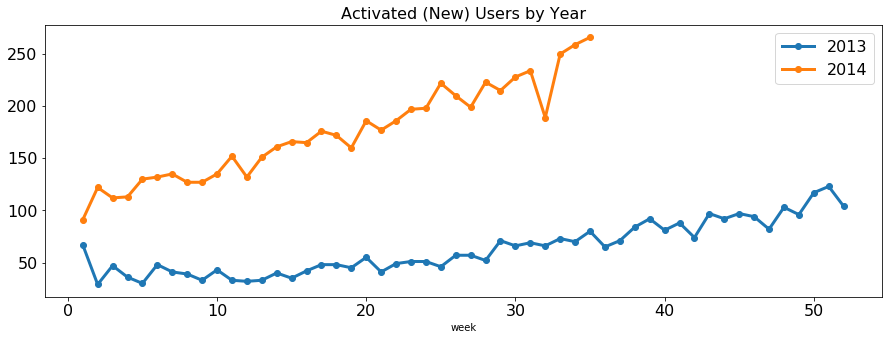

In [8]:
yr1 = df_users.loc[df_users['year'] == 2013].groupby('week').size()
yr2 = df_users.loc[df_users['year'] == 2014].groupby('week').size()
yr1.plot(label="2013", figsize=(15, 5), fontsize=16, marker='o', linewidth = 3)
yr2.plot(label="2014", figsize=(15, 5), fontsize=16, marker='o', linewidth = 3)
plt.title('Activated (New) Users by Year',fontsize=16)
plt.legend(fontsize=16)

It seems like there was a dip in new users around week 32 of 2014 that is sharper than any other part of the trend (especially during a period of growth). This trend returns a week later, indicating that perhaps something was wrong with the sign-up process in week 31/32. Needs a closer look.

#### Create dataframe for sign up flow users

In [9]:
# Examine only those users active/engaged in the service
signup = df[df['event_type'] == 'signup_flow']
# Assign value to day of week
signup['day_of_week'] = signup['occurred_at'].dt.dayofweek

date_assignments(signup,'occurred_at')

# Only need one signup activity to be considered active - remove multiple instances in same day
signup = signup.drop_duplicates(subset=['user_id','date'], keep='first')
signup.head()

,user_id,created_at,company_id,language,activated_at,state,occurred_at,event_type,event_name,location,device,user_type,day_of_week,date,time,day,week,month,year
194211,11768.0,2014-05-01 08:01:36,8099.0,french,2014-05-01 08:03:12,active,2014-05-01 08:01:36,signup_flow,create_user,France,macbook pro,NaN,3,2014-05-01,08:01:36,1,18,5,2014
194222,11770.0,2014-05-01 06:07:24,7847.0,japanese,2014-05-01 06:08:50,active,2014-05-01 06:07:24,signup_flow,create_user,Japan,iphone 5s,NaN,3,2014-05-01,06:07:24,1,18,5,2014
194232,11775.0,2014-05-01 16:36:49,5545.0,english,2014-05-01 16:38:06,active,2014-05-01 16:36:49,signup_flow,create_user,United Kingdom,lenovo thinkpad,NaN,3,2014-05-01,16:36:49,1,18,5,2014
194286,11778.0,2014-05-01 18:48:21,3059.0,english,2014-05-01 18:49:49,active,2014-05-01 18:48:21,signup_flow,create_user,Indonesia,iphone 4s,NaN,3,2014-05-01,18:48:21,1,18,5,2014
194309,11779.0,2014-05-01 18:23:21,10905.0,german,2014-05-01 18:24:54,active,2014-05-01 18:23:21,signup_flow,create_user,Germany,samsung galaxy s4,NaN,3,2014-05-01,18:23:21,1,18,5,2014


#### Create dataframe for active users

In [10]:
# Examine only those users active/engaged in the service
active = df[df['event_type'] == 'engagement']
# Assign value to day of week
active['day_of_week'] = active['occurred_at'].dt.dayofweek

date_assignments(active,'occurred_at')

# Only need one engagement activity to be considered active - remove multiple instances in same day
active = active.drop_duplicates(subset=['user_id','date'], keep='first')
active.head()

,user_id,created_at,company_id,language,activated_at,state,occurred_at,event_type,event_name,location,device,user_type,day_of_week,date,time,day,week,month,year
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active,2014-05-13 09:31:47,engagement,login,India,lenovo thinkpad,3.0,1,2014-05-13,09:31:47,13,20,5,2014
8,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active,2014-05-24 11:39:53,engagement,login,India,samsung galaxy s4,3.0,5,2014-05-24,11:39:53,24,21,5,2014
10,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active,2014-05-31 15:58:46,engagement,login,India,lenovo thinkpad,3.0,5,2014-05-31,15:58:46,31,22,5,2014
20,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active,2014-05-20 09:31:30,engagement,login,India,samsung galaxy s4,3.0,1,2014-05-20,09:31:30,20,21,5,2014
26,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active,2014-05-27 15:09:09,engagement,login,India,lenovo thinkpad,3.0,1,2014-05-27,15:09:09,27,22,5,2014


In [11]:
date_assignments(df_emails,'occurred_at')

### What is the common trend of daily active users?

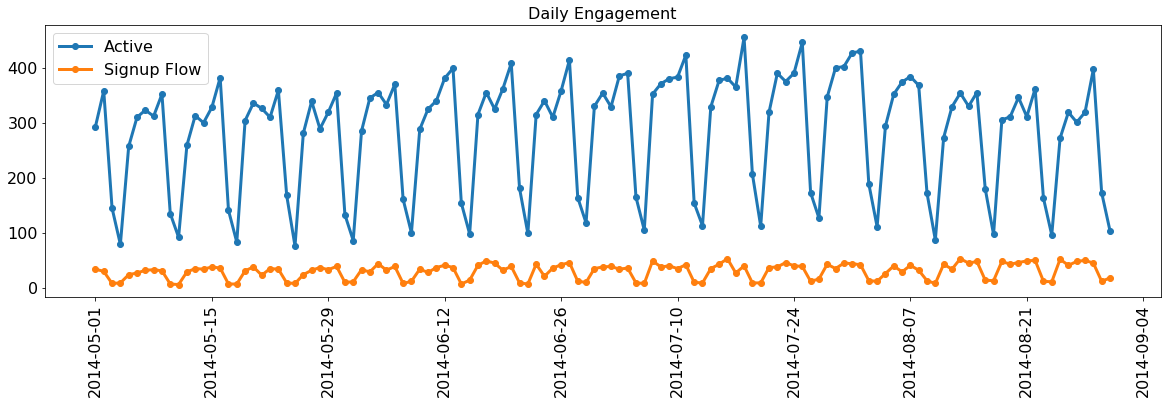

In [12]:
active['date'].value_counts().plot(figsize=(20, 5), fontsize=16, marker='o', linewidth = 3)
signup['date'].value_counts().plot(figsize=(20, 5), fontsize=16, marker='o', linewidth = 3)
plt.xticks(rotation='vertical')
plt.legend('Active Users','Signup Flow')
plt.title('Daily Engagement',fontsize=16)
plt.legend(['Active','Signup Flow'],fontsize=16)

The trend appears mostly consistent across all weeks. You can begin to see less engagement beginning in August, but it doesn't look reflected in signups.

#### Isolate business days - does it make a difference?

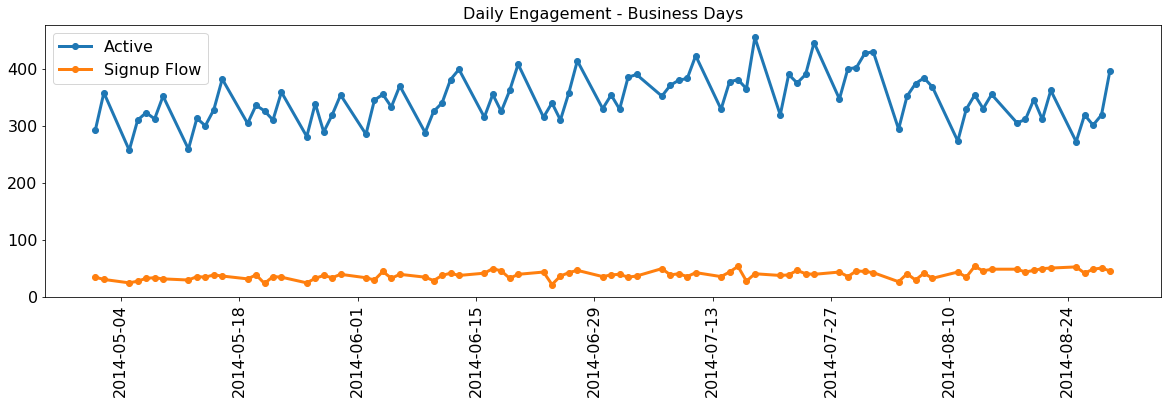

In [13]:
busin = active[active['day_of_week'] < 5]
busin2 = signup[signup['day_of_week'] < 5]
busin['date'].value_counts().plot(figsize=(20, 5), fontsize=16, marker='o', linewidth = 3)
busin2['date'].value_counts().plot(figsize=(20, 5), fontsize=16, marker='o', linewidth = 3)
plt.xticks(rotation='vertical')
plt.legend('Active Users','Signup Flow')
plt.title('Daily Engagement - Business Days',fontsize=16)
plt.legend(['Active','Signup Flow'],fontsize=16)

The picture of user engagement becomes clearer, but the trend stays the same

Okay, so let's isolate exactly when this negative engagement trend begins

Text(0.5,1,'Weekly Active Users')

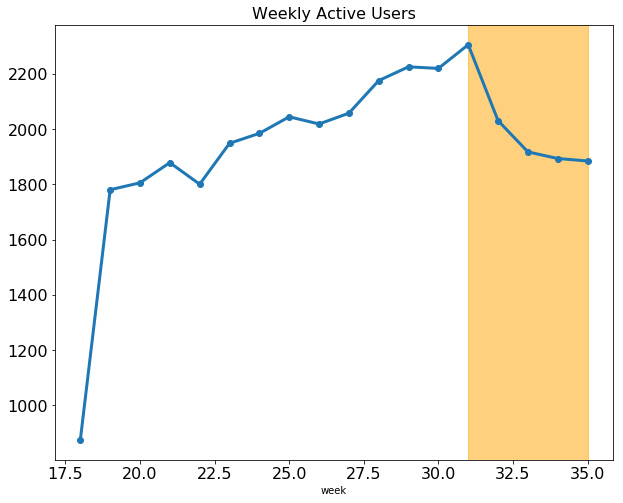

In [14]:
week_engaged = active.groupby('week').size()
week_engaged.plot(figsize=(10, 8), fontsize=16, marker='o', linewidth = 3)
plt.axvspan(31, 35, alpha=0.5, color='orange')
plt.title('Weekly Active Users',fontsize=16)

Week 31 is where it starts.

#### Is this reflected in how emails are accepted?

In [15]:
df_emails['action'].unique()

array(['sent_weekly_digest', 'email_open', 'email_clickthrough',
       'sent_reengagement_email'], dtype=object)

Text(0.5,1,'Weekly Emails Opened')

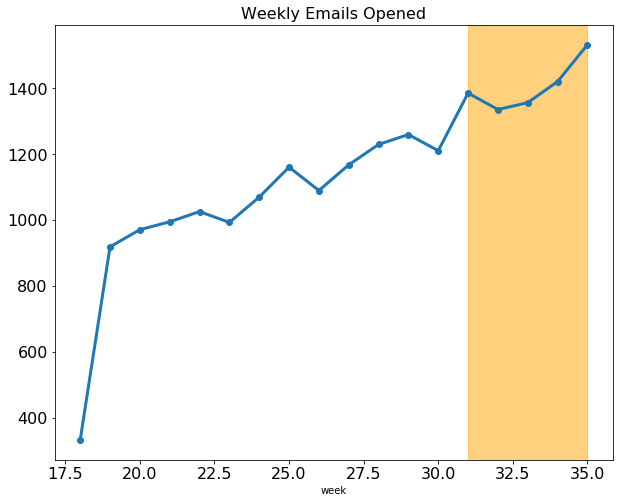

In [16]:
emails_opened = df_emails.loc[df_emails['action'] == 'email_open']
week_emails = emails_opened.groupby('week').size()
week_emails.plot(figsize=(10, 8), fontsize=16, marker='o', linewidth = 3)
plt.axvspan(31, 35, alpha=0.5, color='orange')
plt.title('Weekly Emails Opened',fontsize=16)

There's a small dip, but overall users are still opening their emails in a increasing trend. The issue must be something specifically with the Yammer website itself.

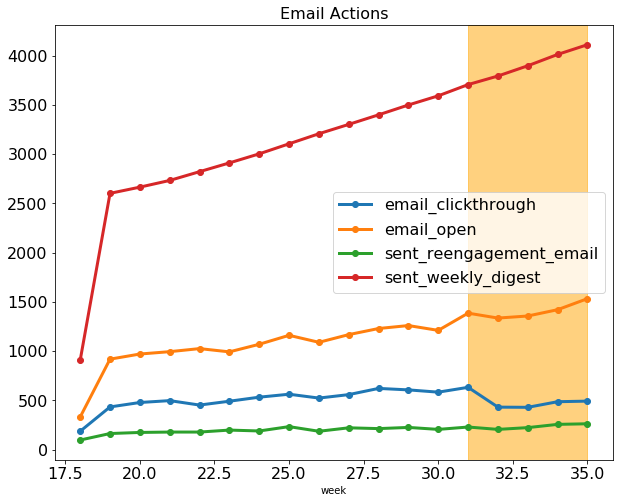

In [17]:
emails = df_emails.groupby(['week','action']).size().unstack()
emails.plot(figsize=(10, 8), fontsize=16, marker='o', linewidth = 3)
plt.axvspan(31, 35, alpha=0.5, color='orange')
plt.title('Email Actions',fontsize=16)
plt.legend(fontsize=16)

The number of emails sent is increasing, which corresponds with increasing numbers of new users. The emails are opened and there is no change to reengagement, but is seems like email clickthrough saw a decrease at week 31. Does this mean there was an issue with accessing Yammer itself?

### Demographic breakdown: How are these people distributed?

To test the hypothesis that perhaps summer holiday is the cause for decrease in engagement, let's look at trends across the world.

#### Location demographic breakdown

In [18]:
active_month = active[(active['year']==2014) & (active['month']==8)]

Text(0.5,1,'Users Active in the Last Month (August)')

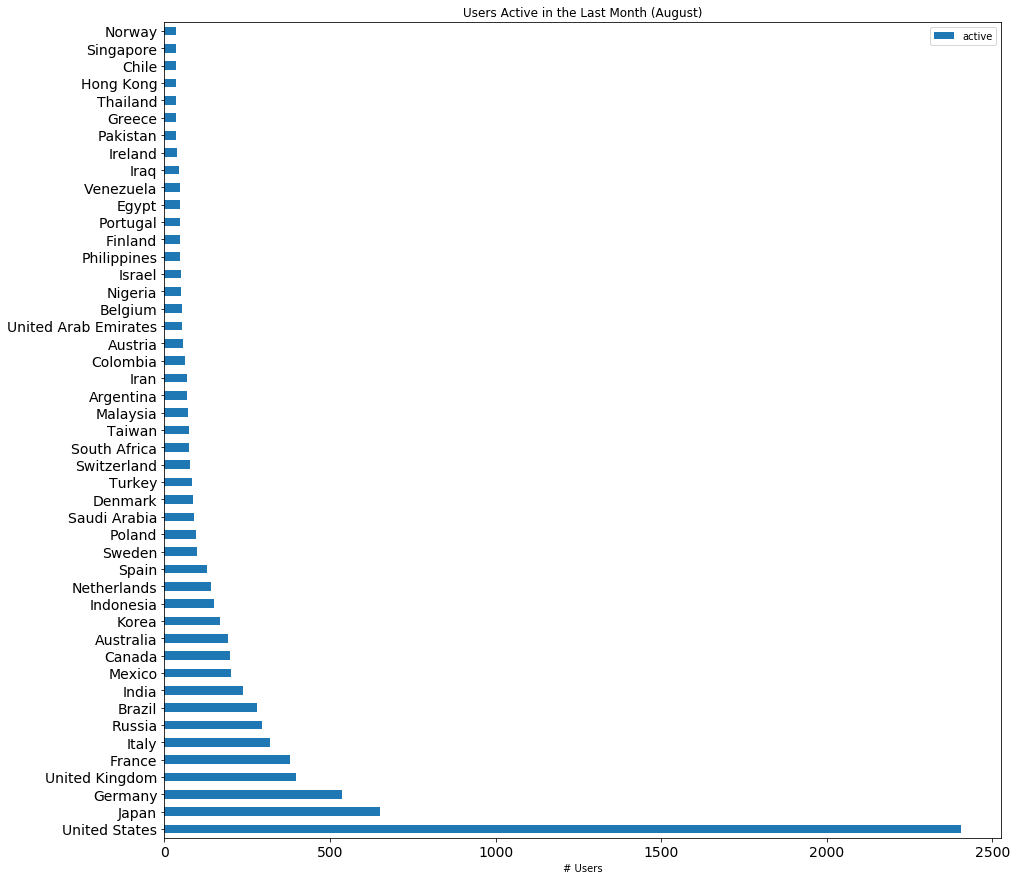

In [19]:
location = pd.DataFrame()
#location['total'] = df['location'].value_counts()
location['active'] = active_month['location'].value_counts()
location.plot(kind='barh', figsize=(15,15), fontsize=14)
plt.xlabel('# Users')
plt.title('Users Active in the Last Month (August)')

Some notes:
* The US, Japan and Germany are the only countries with >500 active members in the system
* Most countries retain active membership, but not a lot

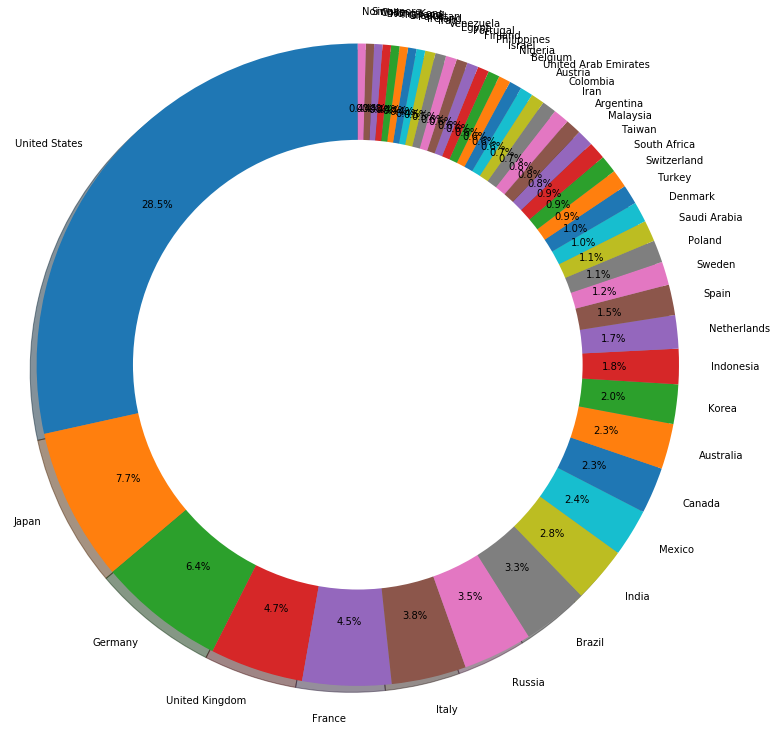

In [20]:
fig = plt.figure(figsize=[10, 10])
plt.pie(location['active'], labels=location.index, autopct='%1.1f%%',
        shadow=True, startangle=90, pctdistance=0.8)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()
plt.show()

The US contributes about 28% of active Yammer users

#### Langage Breakdown

Text(0.5,0,'# Users')

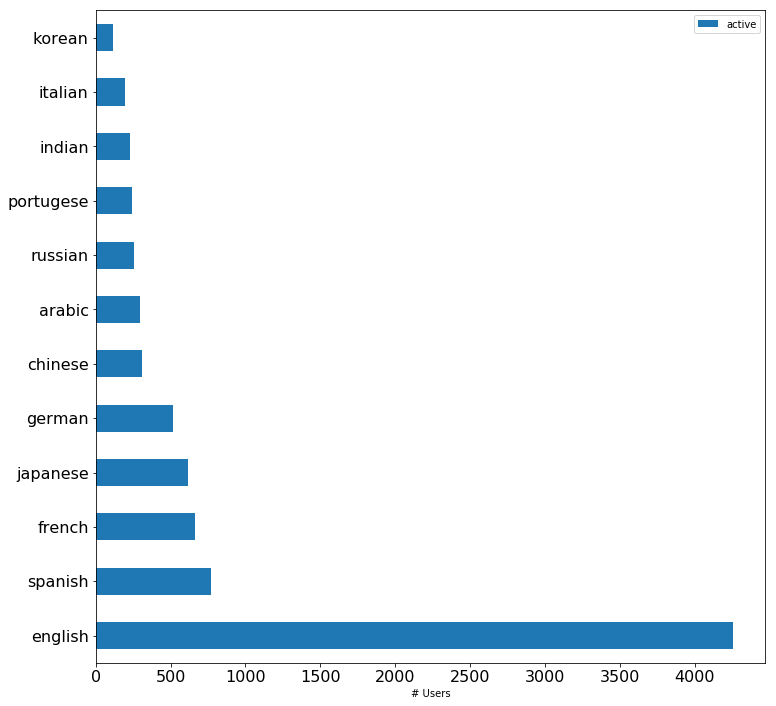

In [21]:
language = pd.DataFrame()
#language['total'] = df['language'].value_counts()
language['active'] = active_month['language'].value_counts()
language.plot(kind='barh', figsize=(12,12), fontsize=16)
plt.xlabel('# Users')

Majority of Yammer users speak English

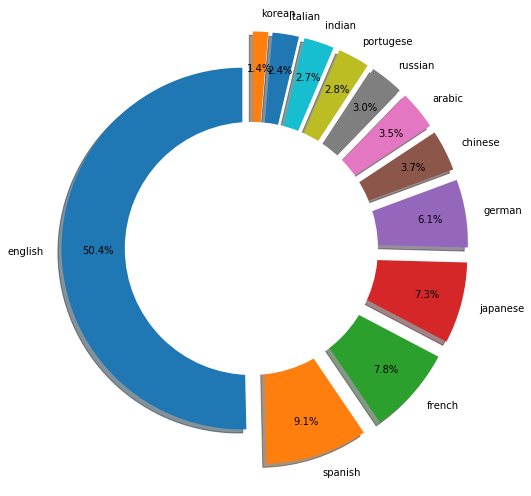

In [22]:
fig = plt.figure(figsize=[7, 7])
explode = (0.05,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2)
plt.pie(language['active'], explode=explode, labels=language.index, autopct='%1.1f%%',
        shadow=True, startangle=90, pctdistance=0.8)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()
plt.show()

Just for further clarification - English users are about 50% of total Yammer users, with Spanish the next most frequent at 9%. This is just to gain a better understanding of the demog.

Text(0.5,1,'Active Users per Country')

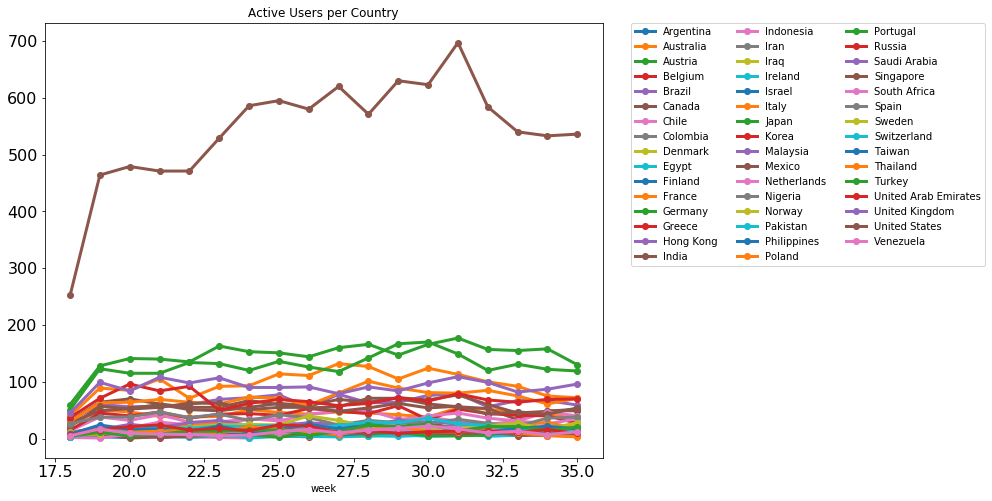

In [23]:
active.groupby(['week','location']).size().unstack().plot(figsize=(10, 8), fontsize=16, linewidth=3.0, marker='o')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=3, borderaxespad=0)
plt.title('Active Users per Country')

It looks like the US has more of a dip in users, but this plot is very busy, so it should be broken down.

#### Okay, let's take a look at the largest population - the US - and see if that differs from the rest of the world.

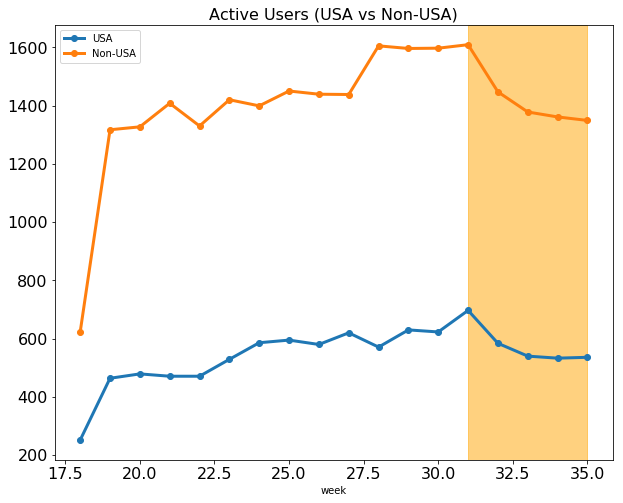

In [24]:
usa = active.loc[active['location'] == 'United States']
nonusa = active.loc[active['location'] != 'United States']
usa = usa.drop_duplicates(subset=['user_id','day','week','month','year'], keep='first')
nonusa = nonusa.drop_duplicates(subset=['user_id','day','week','month','year'], keep='first')

usa2 = usa.groupby('week').size()
nonusa2 = nonusa.groupby('week').size()
usa2.plot(label="USA", figsize=(10, 8), fontsize=16, linewidth=3.0, marker='o')
nonusa2.plot(label="Non-USA", figsize=(10, 8), fontsize=16, linewidth=3.0, marker='o')
plt.axvspan(31, 35, alpha=0.5, color='orange')
plt.title('Active Users (USA vs Non-USA)',fontsize=16)
plt.legend()

Similar trends begin at the same time (week 31) - the issue looks more prevalent in the US, but this could just be because of higher user counts. If there was more time, I could break this down further -- i.e. look at just European countries versus N. American, S. American, etc. (Many European countries take August off)

### What about the summer holiday?
Many people take some vacation in the summer if they can - often times right before the season ends, in August. Summer would be in the northern hemisphere; it will be winter in countries in the southern hemisphere and maybe less opportunities for vacation. Let's see if there is a difference in trends.

##### For simplicity and time-saving, I will only test the US vs a selection of southern hemisphere countries with the largest Yammer userbase: Brazil, Australia, S. Africa, Venezuela and Argentina

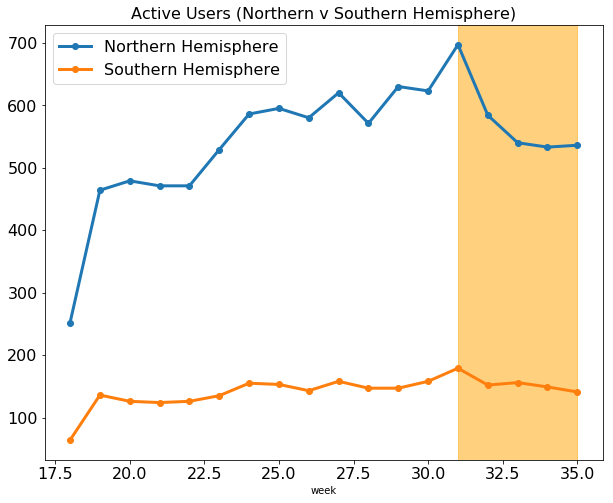

In [25]:
locx = active['location']
southern = active[(locx == 'Brazil') | (locx == 'Australia') | (locx == 'South Africa') | (locx == 'Venezuela') | (locx == 'Argentina')]
southern = southern.drop_duplicates(subset=['user_id','day','week','month','year'], keep='first')

south = southern.groupby('week').size()
usa2.plot(label="Northern Hemisphere", figsize=(10, 8), fontsize=16, linewidth=3.0, marker='o')
south.plot(label="Southern Hemisphere", figsize=(10, 8), fontsize=16, linewidth=3.0, marker='o')
plt.axvspan(31, 35, alpha=0.5, color='orange')
plt.title('Active Users (Northern v Southern Hemisphere)',fontsize=16)
plt.legend(fontsize=16)

This is intriguing. While there is a small decrease in engagement in the Southern hemisphere, it is not as severe as in the northern (USA) and appears to just return to its base plateau. These data are a quick snapshot -- it would need to be investigated with all countries, but this could factor into the week 31 drop.
* Right now, it looks like summer time in Northern hemisphere countries could indeed play a part in less engagement.

### How does device play a part?
Testing the hypothesis of whether there was an issue with the website or mobile app -- was there a difference between the two?

In [26]:
active['device'].unique()

array(['lenovo thinkpad', 'samsung galaxy s4', 'dell inspiron desktop',
       'nexus 7', 'macbook pro', 'iphone 5s', 'iphone 4s', 'ipad air',
       'iphone 5', 'kindle fire', 'asus chromebook', 'nexus 5',
       'hp pavilion desktop', 'macbook air', 'acer aspire notebook',
       'htc one', 'mac mini', 'amazon fire phone', 'acer aspire desktop',
       'dell inspiron notebook', 'nokia lumia 635', 'ipad mini',
       'nexus 10', 'windows surface', 'samsumg galaxy tablet',
       'samsung galaxy note'], dtype=object)

##### A little categorization...by brute force for now

In [27]:
def device_category(df,column):
    df.loc[df[column] == 'lenovo thinkpad','device_cat'] = 'computer'
    df.loc[df[column] == 'samsung galaxy s4','device_cat'] = 'phone/tablet'
    df.loc[df[column] == 'dell inspiron desktop','device_cat'] = 'computer'
    df.loc[df[column] == 'nexus 7','device_cat'] = 'phone/tablet'
    df.loc[df[column] == 'macbook pro','device_cat'] = 'computer'
    df.loc[df[column] == 'iphone 5s','device_cat'] = 'phone/tablet'
    df.loc[df[column] == 'iphone 4s','device_cat'] = 'phone/tablet'
    df.loc[df[column] == 'ipad air','device_cat'] = 'tablet'
    df.loc[df[column] == 'iphone 5','device_cat'] = 'phone/tablet'
    df.loc[df[column] == 'kindle fire','device_cat'] = 'phone/tablet'
    df.loc[df[column] == 'asus chromebook','device_cat'] = 'computer'
    df.loc[df[column] == 'nexus 5','device_cat'] = 'phone/tablet'
    df.loc[df[column] == 'hp pavilion desktop','device_cat'] = 'computer'
    df.loc[df[column] == 'macbook air','device_cat'] = 'computer'
    df.loc[df[column] == 'acer aspire notebook','device_cat'] = 'computer'
    df.loc[df[column] == 'htc one','device_cat'] = 'phone/tablet'
    df.loc[df[column] == 'mac mini','device_cat'] = 'computer'
    df.loc[df[column] == 'amazon fire phone','device_cat'] = 'phone/tablet'
    df.loc[df[column] == 'acer aspire desktop','device_cat'] = 'computer'
    df.loc[df[column] == 'dell inspiron notebook','device_cat'] = 'computer'
    df.loc[df[column] == 'nokia lumia 635','device_cat'] = 'phone/tablet'
    df.loc[df[column] == 'ipad mini','device_cat'] = 'phone/tablet'
    df.loc[df[column] == 'nexus 10','device_cat'] = 'phone/tablet'
    df.loc[df[column] == 'windows surface','device_cat'] = 'phone/tablet'
    df.loc[df[column] == 'samsumg galaxy tablet','device_cat'] = 'phone/tablet'
    df.loc[df[column] == 'samsung galaxy note','device_cat'] = 'phone/tablet'

In [28]:
device_category(active,'device')
device_category(df,'device')
device_category(signup,'device')

Text(0.5,0,'Week')

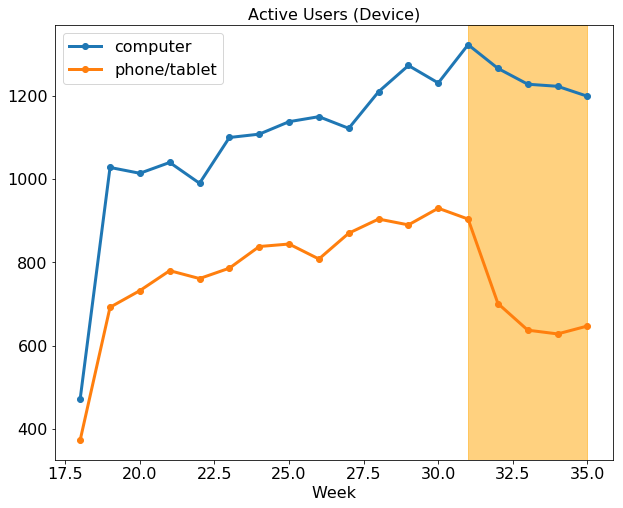

In [29]:
computer = active.loc[active['device_cat'] == 'computer'].groupby('week').size()
phone = active.loc[active['device_cat'] == 'phone/tablet'].groupby('week').size()

computer.plot(label="computer", figsize=(10, 8), fontsize=16, linewidth=3.0, marker='o')
phone.plot(label="phone/tablet", figsize=(10, 8), fontsize=16, linewidth=3.0, marker='o')

plt.title('Active Users (Device)', fontsize=16)
plt.axvspan(31, 35, alpha=0.5, color='orange')
plt.legend(fontsize=16)
plt.xlabel('Week',fontsize=16)

This is also interesting. While yes, there is a decrease in engagement in computers at week 31, it doesn't decrease more than it's plateau from weeks 20-27. In phones and tablets, however, there is a more significant dip. This is something that needs to be investigated within Yammer - was there an issue with the mobile app?

#### Does this compare to new user signups?

Text(0.5,0,'Week')

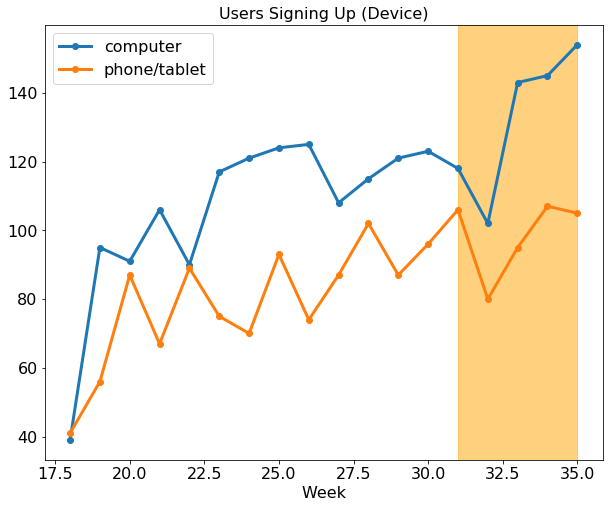

In [30]:
signup = signup.drop_duplicates(subset=['user_id','date'], keep='first')

computer2 = signup.loc[signup['device_cat'] == 'computer'].groupby('week').size()
phone2 = signup.loc[signup['device_cat'] == 'phone/tablet'].groupby('week').size()

computer2.plot(label="computer", figsize=(10, 8), fontsize=16, linewidth=3.0, marker='o')
phone2.plot(label="phone/tablet", figsize=(10, 8), fontsize=16, linewidth=3.0, marker='o')

plt.title('Users Signing Up (Device)', fontsize=16)
plt.axvspan(31, 35, alpha=0.5, color='orange')
plt.legend(fontsize=16)
plt.xlabel('Week',fontsize=16)

Comparing the signups to the active users supports the idea that it is something wrong with the app features and maybe also the ability to create a new user. The dip at week 31 is comparable in both categories, which is then changed a week later to a sharp increase in new users. Maybe there was a fix in the app?

# Summary
* Do the answers to any of your original hypotheses lead you to further questions?
    * There are appears to be some evidence that a summer holiday in the northern hemisphere countries could play a part in a decline in engagement, since little decrease was observed in a selection of southern hemisphere countries.
    * There also appears to be a problem with the mobile version of Yammer, as there was more indication of decreased engagement via the mobile app versus the browser/computer users.
* If they are questions that you can’t answer using data alone, how would you go about answering them (hypothetically, assuming you actually worked at this company)?
    * This is something that could be investigated within the company: ask IT if there were any updates made to the mobile platform in last July/early August (before week 31) that could have disrupted operations
    * Ask higher ups what employee vacation times looked like - or average work hours for each week
* What seems like the most likely cause of the engagement dip?
    * A decrease in new users in week 31 is indicative of something more than just vacation. It leads one to believe that something was wrong with the actual Yammer program
    * This is supported by the device data -- something was wrong with the mobile platform
    * Email clickthrough is down compared to actually opening the emails. Again, something could have been wrong with the platform to prevent access to Yammer.
* What, if anything, should the company do in response?
    * Investigate the newest updates for issues / bugs
    * Send more emails to reengage those that aren't clicking through - offer incentives
    * Wait a couple weeks to see if people return from vacations

## What more can be done?
### Forecasting: An ARIMA model to see if this trend will continue

In [31]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels as sm

### If I had some more time, this would be the next step!